In [418]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [419]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [420]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu=torch.device("cpu")
print("Using device: ", device)

Using device:  cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [421]:
transform = transforms.Compose(
    [
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

batch_size = 100

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [422]:
import os
from PIL import Image
school_labels = ["zxb","nm","sy","tsg","mhb","sjz","tyht"]
other_labels = ["all_souls","ashmolean","balliol","bodleian","christ_church","cornmarket","hertford","jesus","keble","magdalen","new","oriel","oxford","pitt_rivers","radcliffe_camera","trinity","worcester"]
all_labels = school_labels + ["other"] #other_labels
print(len(all_labels))

label_dict = {}
for i, tag in enumerate(all_labels):
    label_dict[tag] = i


class BJTUDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train
        self.image_files = os.listdir(root)
        self.image_paths = [os.path.join(root, imgf) for imgf in self.image_files]
        # self.images = [Image.open(image_path) for image_path in self.image_paths]
        # self.images = []
        cot=0
        # for image_path in self.image_paths:
            

        #     try:
        #         cot+=1
        #         self.images.append(Image.open(image_path))
        #         print("{} images loaded".format(cot))
        #     except Exception as err:
        #         print(err)
        #         print("Invalid image: {}".format(image_path))
        #         self.image_paths.remove(image_path)
        
        self.prelabels = [img.split('-')[0] for img in self.image_files]
        for i, label in enumerate(self.prelabels):
            if label in school_labels:
                self.prelabels[i] = label
            else:
                self.prelabels[i] = "other"
                
        self.labels = [label_dict[label] for label in self.prelabels]
        # self.N = len(self.image_files)
        #print first 10 labels
        print(self.labels[:500])
        #print first 10 image paths
        print(self.image_paths[:10])
        




    def __len__(self):
        # print("Total images: {}".format(self.N))
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = Image.open(self.image_paths[idx])
        # print("Reading image: {}".format(self.image_paths[idx]))
        # image = self.images[idx]
        # self.transform = False
        # image = np.array(image)
        if self.transform:
            image = self.transform(image)
        return image, label


8


In [423]:
work_path = "C:\\Left\\Workspace\\BJTU-CVFundamental\\"
data_root = os.path.join(work_path, "data\\bjtu-dataset-mixed\\Cleaned_Dataset_256p\\")

trainset = BJTUDataset(root=data_root+'train', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = BJTUDataset(root=data_root+'test', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

# for _ in range(3):
#    t1 = time.time()
#    for idx, val in enumerate(testloader):
#        pass
#    t2 = time.time()
#    print(str(t2-t1) +' sec')

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

Let us show some of the training images, for fun.



In [424]:
# train_features, train_labels = next(iter(trainloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")

In [425]:


# print((trainset[0][0].numpy().shape))

# plt.imshow(trainset[0][0].permute(1, 2, 0).numpy())

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{all_labels[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [426]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# net = net.to(device)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [427]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [428]:


print("Start training")
for epoch in range(10):  # loop over the dataset multiple times

    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(trainloader,0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # inputs = inputs.to(device)
        # labels = labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Start training
Epoch 1


0it [00:01, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x476288 and 3200x120)

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



tensor([4, 4, 4, 4])


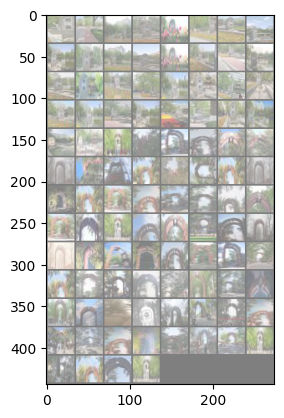

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(labels[:4])
# print('GroundTruth: ', ' '.join(f'{label_dict[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

print(outputs[:4])

tensor([[-0.7816, -0.0423, -0.1128, -0.1450, -0.7243, -0.0534, -0.1690,  2.3238],
        [-0.9498, -0.0357, -0.1326, -0.1530, -0.8721, -0.0484, -0.1984,  2.6822],
        [-0.7913, -0.0457, -0.1110, -0.1354, -0.7335, -0.0559, -0.1678,  2.3411],
        [-0.8273, -0.0455, -0.1186, -0.1420, -0.7665, -0.0535, -0.1725,  2.4176]],
       grad_fn=<SliceBackward0>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print(predicted)

for j in range(4):
    tens=predicted[j]
    print(tens)
    # print(f'Predicted: {label_dict[predicted[j]]:5s} (Ground Truth: {label_dict[labels[j]]:5s})')


tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7])
tensor(7)
tensor(7)
tensor(7)
tensor(7)


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[labels[label]] += 1
            total_pred[labels[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

NameError: name 'classes' is not defined

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter